In [1]:
import io 
import numpy as np
from tqdm import tqdm

import torch
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Audio

## define a pytorch model with a function (`sample`) we would like to export

this is a basic autoregressive model for 1-d sequences. 

it uses parallel operations and the torch.nn.GRU kernel in `forward` for fast training.

it also exposes a method `sample` for predicting the next single sequence element. this is what we'd like to export to audio hardware.

In [702]:
# torch has the logit function but ONNX does not
def logit(x):
    return (x/(1-x)).log()

class TorchLogisticCDF(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.ls_bias = torch.nn.Parameter(torch.ones(1))

    def unpack_params(self, dist_params):
        # chunk appears to trigger a bug/deficiency in TVM
        # loc, log_scale = dist_params.chunk(2,-1)
        loc, log_scale = dist_params[...,:1], dist_params[...,1:]
        return loc, log_scale+self.ls_bias
    
    def likelihood(self, dist_params, target, resolution=256):#65536):
        """
        Args:
            dist_params: Tensor[batch x time x 2]
            target: Tensor[batch x time x 1]
        """
        # likelihood
        # probably not numerically stable
        loc, log_scale = self.unpack_params(dist_params)
        d = torch.tensor([0.5, -0.5])/resolution
        inv_scale = (-log_scale).exp()
        prob = ((((target - loc)[...,None] + d) * inv_scale[...,None]).sigmoid()*d*2).sum(-1)
        return prob.clamp(1e-7, 1e5).log()
        
    def sample(self, dist_params, u=None, temp=1):
        loc, log_scale = self.unpack_params(dist_params)
        scale = log_scale.exp()
        if u is None:
            u = torch.rand(tuple(loc.shape))#torch.rand_like(loc)
        return loc + temp * scale * logit(u)#.logit()
    
# class TorchMixtureLogisticCDF(torch.nn.Module):
#     def __init__(self, n):
#         super().__init__()
#         self.loc_bias = torch.nn.Parameter(torch.zeros(n))
#         self.ls_bias = torch.nn.Parameter(torch.ones(n))
#         self.lp_bias = torch.nn.Parameter(torch.zeros(n))

#     def unpack_params(self, dist_params):
#         # chunk appears to trigger a bug/deficiency in TVM
#         # loc, log_scale, log_pi = dist_params.chunk(3,-1)
#         loc, log_scale, log_pi = dist_params[...,:1], dist_params[...,1:]
#         return loc+self.log_bias, log_scale+self.ls_bias, log_pi+self.lp_bias
    
#     def likelihood(self, dist_params, target, resolution=256):#65536):
#         """
#         Args:
#             dist_params: Tensor[batch x time x 2]
#             target: Tensor[batch x time x 1]
#         """
#         # likelihood
#         loc, log_scale, log_pi = self.unpack_params(dist_params)
        #TODO
        
#     def sample(self, dist_params, u=None, temp=1):
#         loc, log_scale, log_pi = self.unpack_params(dist_params)
        # sample component index from pi
        # index loc, log_scale
        # sample from mixture component
#         return loc + temp * scale * logit(u)#.logit()

class TorchRNN(torch.nn.Module):
    """mixture density network with GRU cell"""
    def __init__(self, emb_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.rnn = torch.nn.GRU(emb_size, hidden_size, batch_first=True)
        self.rnn_cell = torch.nn.GRUCell(emb_size, hidden_size)
        self.rnn_cell.weight_ih = self.rnn.weight_ih_l0
        self.rnn_cell.weight_hh = self.rnn.weight_hh_l0
        self.rnn_cell.bias_ih = self.rnn.bias_ih_l0
        self.rnn_cell.bias_hh = self.rnn.bias_hh_l0
        
        self.h0 = torch.nn.Parameter(torch.randn(1,hidden_size)*hidden_size**-0.5)
        
        # self.proj = torch.nn.Linear(hidden_size, 2, bias=False)
        self.proj = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, 2, bias=False))

        # self.emb = torch.nn.Linear(1, emb_size)
        self.output = TorchLogisticCDF()
        
    def sample(self, h, x, u=None, temp=1):
        """
        Args:
            h: hidden state Tensor[batch x hidden]
            x: sample Tensor[batch x 1]
        Returns: 
            next hidden state Tensor[batch x hidden]
            next sample Tensor[batch x 1]
        """
        x_emb = x#self.emb(x)
        h = self.rnn_cell(x, h)
        dist_params = self.proj(h)
        x = self.output.sample(dist_params, u, temp)
        return h, x
    
    def sample_n(self, h, x_block, n=1, temp=1):
        """
        Args:
            x: sample block [batch x time x 1]
            h: hidden state [batch x hidden]
        Returns: 
            final hidden state Tensor[batch x hidden]
            next sample block Tensor[batch x time x 1]
        """
        xs = []
        x = x_block[:,-1,:]
        for i in range(n):
            h, x = self.sample(h, x, temp=temp)
            xs.append(x)
        return h, torch.stack(xs, -2)
    
    def forward(self, x, temp=0):
        """
        Args:
            x: signal Tensor[batch x time x 1]
        Returns:
            log likelihood Tensor[batch x time]
        """
        x_emb = x + torch.randn_like(x)*temp#self.emb(x)
        h, _ = self.rnn(x_emb, self.h0[None].expand(1, x.shape[0], -1))
        dist_params = self.proj(h[:,:-1])
        return {
            'log_probs': self.output.likelihood(dist_params, x[:,1:]),
            'dist_params': dist_params
        }

In [703]:
rnn = TorchRNN(1, 128)
n = 16 # block size
temp = 0.01 # sampling temperature
sr = 8000 # sampling rate

## Train

train to predict sine waves with random frequency, phase and amplitude

Text(0.5, 1.0, 'random samples of training data')

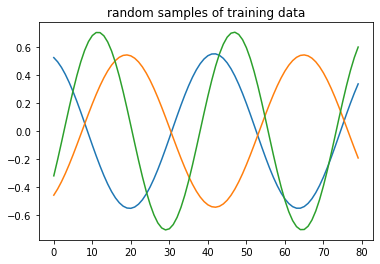

In [704]:
freq = 200
def get_batch(batch_size, length):
    t = torch.arange(length)[None].expand(batch_size, length)
    f = freq * 2**(torch.randn(batch_size, 1)*0.25)
    phase = (t/sr + torch.rand(batch_size, 1))*2*np.pi*f
    gain = 2**(-torch.rand(batch_size, 1))
    signal = phase.cos() * gain
    return signal[:,:,None]

_ = plt.plot(get_batch(3, 80)[:,:,0].T)
plt.title('random samples of training data')

joint distribution of first two audio samples


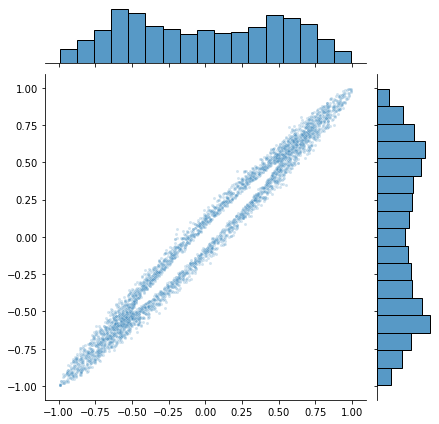

In [705]:
b = get_batch(4000, 2)[:,:,0]
sns.jointplot(x=b[:,1], y=b[:,0], marker='.', alpha=0.2)
print('joint distribution of first two audio samples')

In [706]:
opt = torch.optim.Adam(rnn.parameters(), 1e-4)
grad_clip = 1
batch_size = 32
batch_length = 400 # audio samples
train_temp = 1/256
loss_curve = []
grad_norms = []
grad_norms_ih = []
grad_norms_hh = []
grad_norms_p0 = []
grad_norms_p1 = []
dist_params = []
i = 0

100%|██████████| 1000/1000 [04:37<00:00,  3.60it/s]


Text(0, 0.5, 'loss')

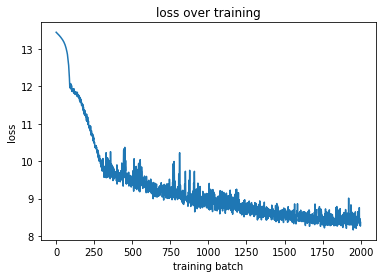

In [734]:
for _ in tqdm(range(1000)):
    i += 1
    opt.zero_grad()
    batch = get_batch(batch_size, batch_length)
    result = rnn(batch, temp=train_temp)
    loss = -result['log_probs'].mean()
    loss.backward()
    grad_norms.append(torch.nn.utils.clip_grad_norm_(rnn.parameters(), grad_clip).item())
    opt.step()
    dist_params.append(result['dist_params'].detach())
    loss_curve.append(loss.item())
    grad_norms_ih.append(rnn.rnn_cell.weight_ih.grad.norm().item())
    grad_norms_hh.append(rnn.rnn_cell.weight_hh.grad.norm().item())
    grad_norms_p0.append(rnn.proj[0].weight.grad.norm().item())
    grad_norms_p1.append(rnn.proj[2].weight.grad.norm().item())
plt.plot(loss_curve)
plt.title('loss over training')
plt.xlabel('training batch')
plt.ylabel('loss')

Text(0, 0.5, '2-norm of gradient')

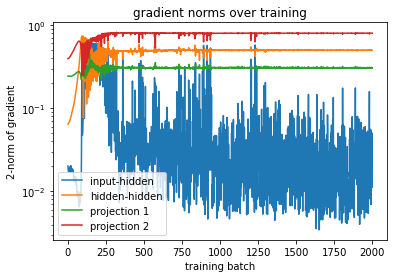

In [735]:
plt.plot(grad_norms_ih, label='input-hidden')
plt.plot(grad_norms_hh, label='hidden-hidden')
plt.plot(grad_norms_p0, label='projection 1')
plt.plot(grad_norms_p1, label='projection 2')
plt.yscale('log')
plt.legend()
plt.title('gradient norms over training')
plt.xlabel('training batch')
plt.ylabel('2-norm of gradient')

Text(0, 0.5, 'probability density')

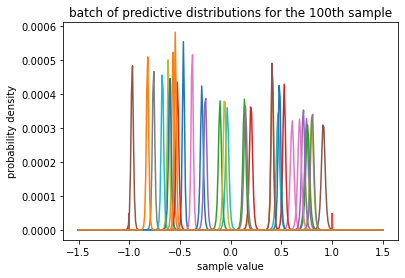

In [736]:
domain = torch.linspace(-1.5,1.5,300)[:,None]
t = 100
sweeps = rnn.output.likelihood(dist_params[-1][:, t:t+1, :], domain).exp().detach()
for sweep in sweeps.unbind(0):
    plt.plot(domain, sweep)
plt.vlines([-1, 1], 0, 5e-5, color='r')
plt.title('batch of predictive distributions for the 100th sample')
plt.xlabel('sample value')
plt.ylabel('probability density')

Text(0, 0.5, 'sample value')

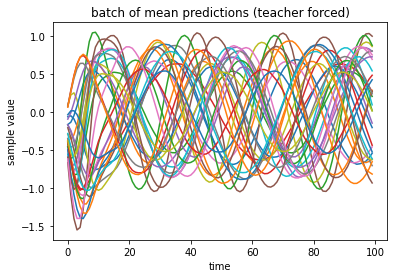

In [737]:
loc, log_scale = dist_params[-1].unbind(-1)
for c in loc.unbind(0):
    plt.plot(c[:100])
plt.title('batch of mean predictions (teacher forced)')
plt.xlabel('time')
plt.ylabel('sample value')

Text(0, 0.5, 'sample value')

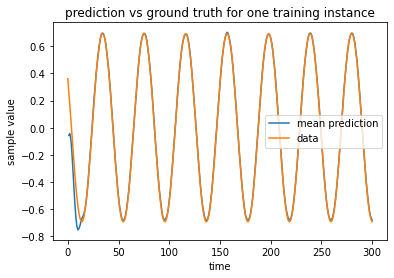

In [738]:
pts = 300
i = 0
plt.plot(range(1,pts+1), loc[i,:pts], label='mean prediction')
plt.plot(range(pts+1), batch[i,:pts+1,0], label='data')
plt.legend()
plt.title('prediction vs ground truth for one training instance')
plt.xlabel('time')
plt.ylabel('sample value')

Text(0, 0.5, 'error')

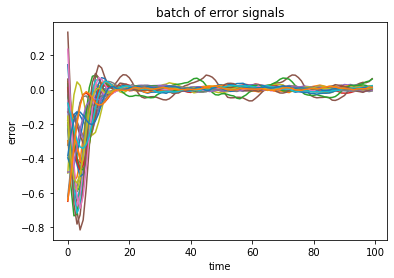

In [739]:
err = loc[:,:100] - batch[:,1:101,0]
for c in err.unbind(0):
    plt.plot(c)
plt.title('batch of error signals')
plt.xlabel('time')
plt.ylabel('error')

Text(0, 0.5, 'log scale')

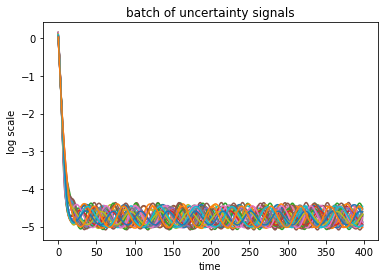

In [740]:
for c in log_scale.unbind(0):
    plt.plot(c[:800]+rnn.output.ls_bias.detach())
plt.title('batch of uncertainty signals')
rnn.output.ls_bias
plt.xlabel('time')
plt.ylabel('log scale')

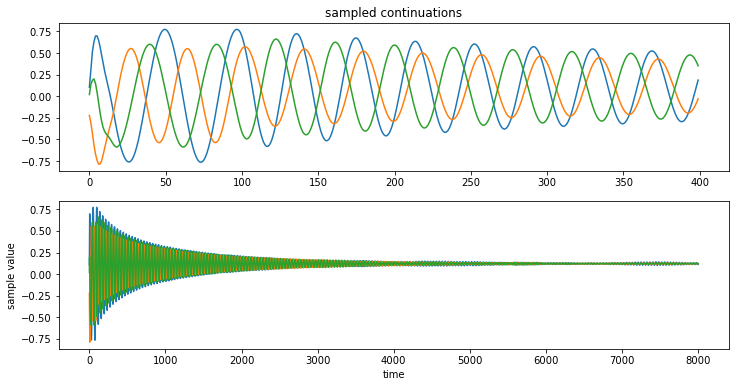

In [744]:
fig, ax = plt.subplots(2,1,figsize=(12,6))
n_prime = 100
prime = get_batch(3, n_prime)
for j in range(3):
    with torch.no_grad():
        h = rnn.h0.detach()
        xs = []
        hs = []
        for i in range(sr):
            if i<prime.shape[1]:
                x = prime[j:j+1,i]
            h, x = rnn.sample(h, x, temp=0.01)
            xs.append(x.item())
            hs.append(h.detach())
        display(Audio(xs, rate=sr))
    ax[0].plot(xs[:400])
    ax[1].plot(xs)
    ax[0].set_title('sampled continuations')
    ax[1].set_xlabel('time')
    ax[1].set_ylabel('sample value')

Text(0, 0.5, 'index of hidden state')

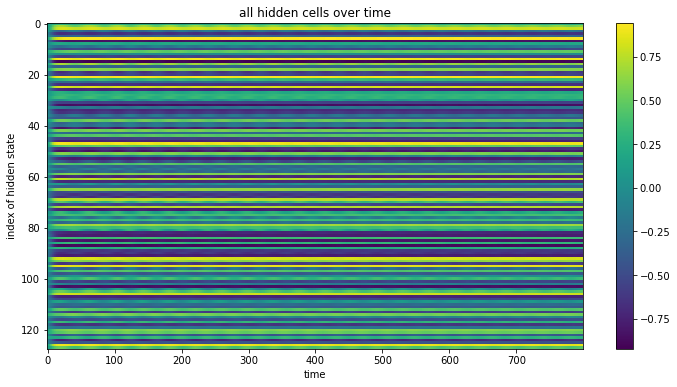

In [745]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
im = torch.cat(hs, 0)
g = ax.imshow(im[:800].T, aspect='auto', interpolation='nearest')
plt.colorbar(g)
plt.title('all hidden cells over time')
plt.xlabel('time')
plt.ylabel('index of hidden state')

Text(0, 0.5, 'value of hidden state')

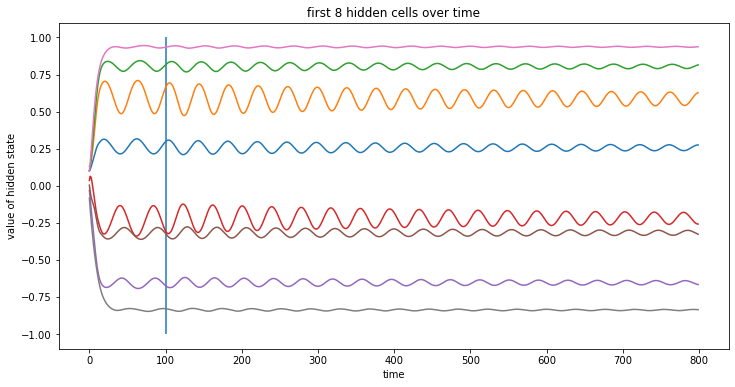

In [746]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
for i in range(8):
    ax.plot(im[:800, i])
plt.vlines([n_prime], -1, 1)
plt.title('first 8 hidden cells over time')
plt.xlabel('time')
plt.ylabel('value of hidden state')

## Performance

### training

In [720]:
%%timeit
rnn(torch.randn(1,sr,1))

600 ms ± 23.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### inference

In [721]:
%%timeit
with torch.no_grad():
    h = rnn.h0.detach()
    x = torch.zeros(1,1)
    xs = []
    for _ in range(sr):
        h, x = rnn.sample(h, x, temp=0.1)
        xs.append(x.item())

1.15 s ± 50.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


without internal RNG:

In [722]:
%%timeit
with torch.no_grad():
    h = rnn.h0.detach()
    x = torch.zeros(1,1)
    xs = []
    for _ in range(sr):
        u = torch.rand(1, 1)
        h, x = rnn.sample(h, x, u=u, temp=temp)
        xs.append(x.item())

1.08 s ± 37.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


in blocks:

In [723]:
%%timeit
with torch.no_grad():
    h = rnn.h0.detach()
    x_block = torch.zeros(1, n, 1)
    xs = []
    for _ in range(sr//n):
        h, x_block = rnn.sample_n(h, x_block, n=n, temp=temp)
        xs.extend(x_block[0, :, 0].detach())

1.09 s ± 78.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [617]:
# h.shape, x.shape, x_block.shape, u.shape

## export to ONNX

In [747]:
opset = 14 #backend.Caffe2Backend._known_opset_version
opset

14

In [748]:
class ExportWrapper(torch.nn.Module):
    """convenience for exporting model function other than `forward`"""
    def __init__(self, instance, fn_name, **kw):
        super().__init__()
        self.model = instance
        self.fn_name = fn_name
        self.kw = kw
        
    def forward(self, *a, **kw):
        return getattr(self.model, self.fn_name)(*a, **kw, **self.kw)

In [749]:
h = rnn.h0.detach()
x = torch.zeros(1,1)
x_block = torch.zeros(1,16,1)
u = torch.rand(1, 1)

onnx_file = 'test.onnx'
torch.onnx.export(
    ExportWrapper(rnn, 'sample', temp=temp), # nn.Module
    (h, x),                                  # model input
    onnx_file,                               # file to save the model
    opset_version=opset,                     # ONNX version
    do_constant_folding=True,
    input_names = ['prev_state', 'input'],  
    output_names = ['next_state', 'output'],
    # verbose=True
)

onnx_file_norng = 'test_norng.onnx'
torch.onnx.export(
    ExportWrapper(rnn, 'sample', temp=temp), 
    (h, x, u),                               
    onnx_file_norng,                         
    opset_version=opset,                     
    do_constant_folding=True,                
    input_names = ['prev_state', 'input', 'rng'], 
    output_names = ['next_state', 'output'],
    # verbose=True
)

onnx_file_block = 'test_block.onnx'
torch.onnx.export(
    ExportWrapper(rnn, 'sample_n', n=n, temp=temp),
    (h, x_block),                  
    onnx_file_block,               
    opset_version=opset,          
    do_constant_folding=True,  
    input_names = ['prev_state', 'input'], 
    output_names = ['next_state', 'output'],
    # verbose=True
)

## load with python onnx package

In [750]:
import onnx
# help(onnx)

In [751]:
# Load the ONNX model
onnx_model = onnx.load(onnx_file)
onnx_model_norng = onnx.load(onnx_file_norng)
onnx_model_block = onnx.load(onnx_file_block)

# Check that the IR is well formed
onnx.checker.check_model(onnx_model)
onnx.checker.check_model(onnx_model_norng)
onnx.checker.check_model(onnx_model_block)

# Print a human readable representation of the graph
print(onnx.helper.printable_graph(onnx_model.graph))

graph torch-jit-export (
  %prev_state[FLOAT, 1x128]
  %input[FLOAT, 1x1]
) initializers (
  %model.rnn.weight_ih_l0[FLOAT, 384x1]
  %model.rnn.weight_hh_l0[FLOAT, 384x128]
  %model.rnn.bias_ih_l0[FLOAT, 384]
  %model.rnn.bias_hh_l0[FLOAT, 384]
  %model.proj.0.weight[FLOAT, 128x128]
  %model.proj.0.bias[FLOAT, 128]
  %model.output.ls_bias[FLOAT, 1]
  %64[FLOAT, 128x2]
  %67[INT64, 2]
) {
  %11 = Gemm[alpha = 1, beta = 1, transB = 1](%input, %model.rnn.weight_ih_l0, %model.rnn.bias_ih_l0)
  %12 = Constant[value = <Tensor>]()
  %13, %14, %15 = Split[axis = 1](%11, %12)
  %16 = Gemm[alpha = 1, beta = 1, transB = 1](%prev_state, %model.rnn.weight_hh_l0, %model.rnn.bias_hh_l0)
  %17 = Constant[value = <Tensor>]()
  %18, %19, %20 = Split[axis = 1](%16, %17)
  %21 = Add(%18, %13)
  %22 = Sigmoid(%21)
  %23 = Add(%19, %14)
  %24 = Sigmoid(%23)
  %25 = Mul(%20, %22)
  %26 = Add(%15, %25)
  %27 = Tanh(%26)
  %28 = Sub(%prev_state, %27)
  %29 = Mul(%28, %24)
  %next_state = Add(%29, %27)
  %31 = 

In [623]:
# onnx_model.graph

## run with caffe2

In [624]:
h = np.zeros((1, rnn.hidden_size), np.float32)
x = np.array([[0.]]).astype(np.float32)
u = np.random.rand(1,1).astype(np.float32)

In [625]:
import caffe2.python.onnx.backend as backend

rep = backend.prepare(onnx_model_norng, device="CPU")
outputs = rep.run((h, x, u))
print(outputs[0])

/Users/victor/anaconda3/envs/rnn-export/lib/python3.9/site-packages/caffe2/python/onnx/backend.py:687: UserWarning: This version of onnx-caffe2 targets ONNX operator set version 9, but the model we are trying to import uses version 14.  We will try to import it anyway, but if the model uses operators which had BC-breaking changes in the intervening versions, import will fail.
  warnings.warn("This version of onnx-caffe2 targets ONNX operator set version {}, but the model we are trying to import uses version {}.  We will try to import it anyway, but if the model uses operators which had BC-breaking changes in the intervening versions, import will fail.".format(cls._known_opset_version, imp.version))
/Users/victor/anaconda3/envs/rnn-export/lib/python3.9/site-packages/caffe2/python/onnx/backend.py:878: UserWarning: ShapeInferenceWarning: utils module not found in ONNX version 1.10.1
  warnings.warn("ShapeInferenceWarning: utils module not found in ONNX version {}".format(onnx.__version__)

RuntimeError: [enforce fail at net.cc:70] . op MatMul: Source for input model.rnn.weight_ih_l0 is unknown for net torch-jit-export_init, operator input: "input" input: "model.rnn.weight_ih_l0" output: "OC2_DUMMY_0" name: "" type: "MatMul" arg { name: "trans_a" i: 0 } arg { name: "trans_b" i: 1 }

caffe2 doesn't do RNG. https://github.com/onnx/onnx-caffe2/blob/master/tests/ONNXOpCoverage.md

even passing in the random source, it will not work...

with torch 1.9.1, doesn't support the current onnx

downgrading onnx did not work either -- onnx.optimizer is there but fails somehow

now with pytorch-nightly and latest onnx, it has this "source for input is unknown" error

## run with onnxruntime

In [752]:
import onnxruntime as ort
ort_session = ort.InferenceSession('test.onnx')
ort_session_norng = ort.InferenceSession('test_norng.onnx')
ort_session_block = ort.InferenceSession('test_block.onnx')

In [753]:
%%timeit
h = np.zeros((1, rnn.hidden_size), np.float32)
x = np.array([[0.]]).astype(np.float32)
xs = []
for _ in range(sr):
    h, x = ort_session.run(None, {'prev_state': h, 'input':x})
    xs.append(x.item())

597 ms ± 16.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [754]:
%%timeit
h = np.zeros((1, rnn.hidden_size), np.float32)
x = np.array([[0.]]).astype(np.float32)
xs = []
for _ in range(sr):
    u = np.random.rand(1,1).astype(np.float32)
    h, x = ort_session_norng.run(None, {'prev_state': h, 'input':x, 'rng':u})
    xs.append(x.item())

653 ms ± 31.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [755]:
%%timeit
h = np.zeros((1, rnn.hidden_size), np.float32)
x_block = np.zeros((1,n,1), np.float32)
xs = []
for _ in range(sr//n):
    h, x_block = ort_session_block.run(None, {'prev_state': h, 'input':x_block})
    xs.extend(x_block[0,:,0])

568 ms ± 32.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


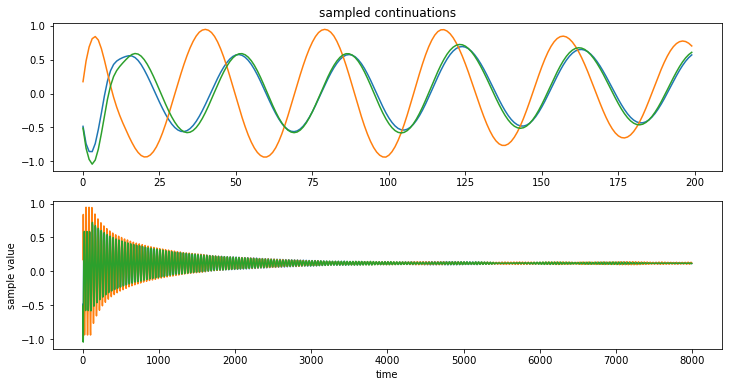

In [758]:
fig, ax = plt.subplots(2,1,figsize=(12,6))
prime = get_batch(3, 100).numpy()
for j in range(3):
    with torch.no_grad():
        h = rnn.h0.detach().numpy()
        xs = []
        hs = []
        for i in range(sr):
            if i<prime.shape[1]:
                x = prime[j:j+1,i]
            h, x = ort_session.run(None, {'prev_state': h, 'input':x})
            xs.append(x.item())
            hs.append(h)
        display(Audio(xs, rate=sr))
    ax[0].plot(xs[:200])
    ax[1].plot(xs)
    ax[0].set_title('sampled continuations')
    ax[1].set_xlabel('time')
    ax[1].set_ylabel('sample value')

onnxruntime is about 2x faster on my mac, which is nice to see

not much benefit from blocks of size 16 though

## run with TVM

In [759]:
import sys
sys.path.append('/Users/victor/tvm/python')
import tvm
from tvm import te
import tvm.relay as relay

In [762]:
tvm_target = 'llvm'

In [763]:
h = np.ones((1, rnn.hidden_size), np.float32)
x = np.zeros((1,1), np.float32)

shape_dict = {'prev_state': h.shape, 'input':x.shape}
mod, params = relay.frontend.from_onnx(onnx_model, shape_dict)

with tvm.transform.PassContext(opt_level=1):
    executor = relay.build_module.create_executor(
        'graph', mod, tvm.cpu(0), tvm_target, params
    ).evaluate()

OpNotImplemented: The following operators are not supported for frontend ONNX: RandomUniformLike

TVM also does not do RNG?

I see some gesture at supporting RandomUniform: https://github.com/apache/tvm/blob/main/python/tvm/relay/frontend/onnx.py#L3913

though the other random operators are not implemented: https://github.com/apache/tvm/blob/main/python/tvm/relay/frontend/onnx.py#L4262

but I can't get torch to export RandomUniform instead of UniformLike...

In [764]:
h = np.ones((1, rnn.hidden_size), np.float32)
x = np.zeros((1,1), np.float32)
u = 0.5*np.ones((1,1), np.float32)

shape_dict = {'prev_state': h.shape, 'input':x.shape, 'rng':u.shape}
mod, params = relay.frontend.from_onnx(onnx_model_norng, shape_dict)

with tvm.transform.PassContext(opt_level=1):
    executor = relay.build_module.create_executor(
        'graph', mod, tvm.cpu(0), tvm_target, params
    ).evaluate()

In [765]:
tvm_h, tvm_x = [torch.from_numpy(item.numpy()) for item in executor(tvm.nd.array(h), tvm.nd.array(x), tvm.nd.array(u))]
tvm_x

tensor([[0.9062]])

In [766]:
%%timeit
h = tvm.nd.array(np.zeros((1, rnn.hidden_size), np.float32))
x = tvm.nd.array(np.array([[0.]]).astype(np.float32))
u = tvm.nd.array(np.zeros((1,1), np.float32))
xs = []
for _ in range(sr):
    # u = tvm.nd.array(np.random.rand(1,1).astype(np.float32))    
    h, x = executor(h, x, u)
    # xs.append(x.numpy().item())

2.57 s ± 614 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


using TVM this way is 2x *slower* on my mac, even without numpy conversions every frame